In [ ]:
# Hot spots for each crime type using agglomerative clustering
# Dataset: crimes.csv

In [1]:
# Read data
import pandas as pd
from dask import dataframe as dk
import numpy as np
data_types = {
    'ID':  np.int64,
    'Case Number':  object,
    'Date': object,
    'Block': object,
    'IUCR': object,
    'Primary Type': object,
    'Description':  object,
    'Location Description': object,
    'Arrest': bool,
    'Domestic': bool,
    'Beat': np.int64,
    'District': np.float64,
    'Ward': np.float64,
    'Community Area': np.float64,
    'FBI Code': object,
    'X Coordinate': np.float64,
    'Y Coordinate': np.float64,
    'Year': np.int64,
    'Updated On': object,
    'Latitude': np.float64,
    'Longitude': np.float64,
    'Location': object
}
df = pd.read_csv('crimes.csv', dtype=data_types)

In [2]:
# Remove X and Y coordinates that equal 0
df = df[df['X Coordinate'] != 0]
df = df[df['Y Coordinate'] != 0]

In [3]:
# Helper functions
from scipy.cluster.hierarchy import dendrogram, leaders, leaves_list, to_tree
import itertools

def split_by_col_value(df, column_name):
    types = df[column_name].unique()
    df_dict = {elem: pd.DataFrame for elem in types}
    for key in df_dict.keys():
        df_dict[key] = df[:][df[column_name] == key]
    return df_dict

def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

def get_leaders(model):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    Z = np.column_stack([children, distance, no_of_observations]).astype(float)
    T = np.asarray(model.fit_predict(sample_coords)).astype('i')
    return leaders(Z, T)[0]

def leaves_ids(model):
    children = model.children_
    distance = np.arange(children.shape[0])
    no_of_observations = np.arange(2, children.shape[0]+2)
    Z = np.column_stack([children, distance, no_of_observations]).astype(float)
    T = np.asarray(model.fit_predict(sample_coords)).astype('i')
    return leaves_list(Z)

def make_tree(model, X):
    ii = itertools.count(X.shape[0])
    tree = dict()
    for x in model.children_:
        tree[next(ii)] = [x[0], x[1]]
    return tree

In [4]:
# Agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt

def do_clustering(X, **kwargs):
    model = AgglomerativeClustering(**kwargs)
    y = model.fit_predict(X)
    return y

def grouped(X, y):
    uniq = set(y)
    ret = dict()
    for n in uniq:
        indexes = [index for index in range(len(y)) if y[index] == n]
        ret[n] = X.iloc[indexes]
    return ret

def mean_pts(X, y):
    uniq = set(y)
    ret = dict()
    for n in uniq:
        indexes = [index for index in range(len(y)) if y[index] == n]
        grouped = X.iloc[indexes]
        ret[n] = [ np.mean(grouped['X Coordinate']), np.mean(grouped['Y Coordinate']) ]
    return pd.DataFrame(ret.values(), columns=['X Coordinate', 'Y Coordinate'])

In [5]:
# Split by crime type
dfs = split_by_col_value(df, 'Primary Type')

In [6]:
n_clusters_for_crime_type = dict()
for k in dfs.keys():
    n_clusters_for_crime_type[k] = 5 # default

# Override as necessary
n_clusters_for_crime_type['RITUALISM'] = 3

In [11]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

x_range=(-91.686565684,-87.524529378)
y_range=(36.619446395,42.022910333)

def plot_map(df):
    cvs = ds.Canvas(plot_width=800, plot_height=500)
    agg = cvs.points(df, 'X Coordinate', 'Y Coordinate')
    return tf.interpolate(agg, cmap=['blue', 'green'], how='eq_hist')

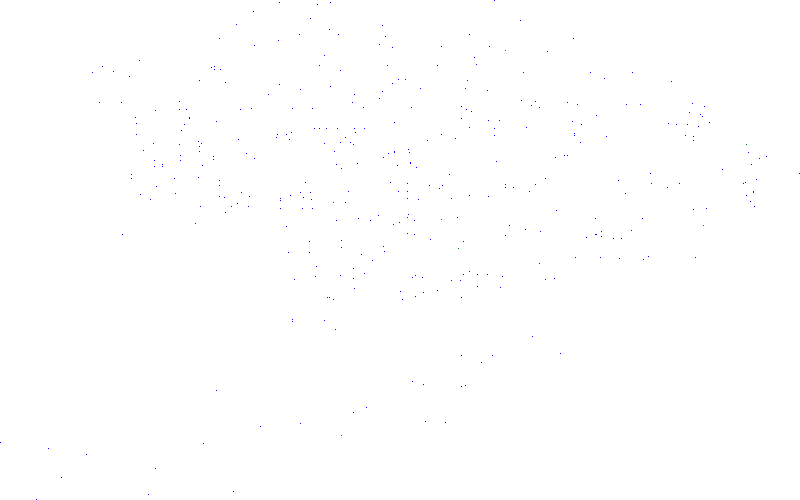

In [16]:
x = None

for crime_type in dfs.keys():
    if crime_type == 'ASSAULT':
        coords = dfs[crime_type][['X Coordinate', 'Y Coordinate']]
        coords = coords.dropna().sample(1000)
        y = do_clustering(coords, n_clusters=n_clusters_for_crime_type[crime_type])
        pts = grouped(coords, y) # TODO: fix: grouped returns a dict for all crime_types, but we use only one at a time
        x = plot_map(pts[0]) # TODO: plots one cluster for now

x

In [22]:
dfs.keys()

['KIDNAPPING',
 'HOMICIDE',
 'CONCEALED CARRY LICENSE VIOLATION',
 'PUBLIC PEACE VIOLATION',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'PROSTITUTION',
 'LIQUOR LAW VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'BURGLARY',
 'WEAPONS VIOLATION',
 'HUMAN TRAFFICKING',
 'OTHER NARCOTIC VIOLATION',
 'OBSCENITY',
 'OTHER OFFENSE',
 'CRIMINAL DAMAGE',
 'MOTOR VEHICLE THEFT',
 'THEFT',
 'OFFENSE INVOLVING CHILDREN',
 'GAMBLING',
 'PUBLIC INDECENCY',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'ARSON',
 'NARCOTICS',
 'SEX OFFENSE',
 'INTIMIDATION',
 'DECEPTIVE PRACTICE',
 'BATTERY',
 'NON - CRIMINAL',
 'CRIMINAL TRESPASS',
 'STALKING',
 'ASSAULT',
 'CRIM SEXUAL ASSAULT',
 'NON-CRIMINAL',
 'DOMESTIC VIOLENCE']